In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/cleaned_fatality_data.csv")
df_ped = df[df['deceased'] == 'Pedestrian'].copy()

In [3]:
df_ped.head()

,unique_id,case_id_fkey,latitude,longitude,collision_year,death_date,death_time,death_datetime,collision_date,collision_time,...,supervisor_district,police_district,data_as_of,data_loaded_at,year,month,day,hour,month_name,time_of_day
0,1,140236301,37.710409,-122.404226,2014,2014-03-20,11:21:00,2014-03-20 11:21:00,2014-03-20,NaN,...,10.0,INGLESIDE,2024-09-18,2025-11-06 10:51:39,2014,3,20,0,March,Night (00–05)
1,2,140755533,37.725476,-122.394243,2014,2014-09-08,16:38:00,2014-09-08 16:38:00,2014-09-08,05:10:00,...,10.0,BAYVIEW,2024-09-18,2025-11-06 10:51:39,2014,9,8,5,September,Night (00–05)
4,17,140104811,37.778251,-122.419883,2014,2014-02-06,10:20:00,2014-02-06 10:20:00,2014-02-05,02:26:00,...,5.0,NORTHERN,2024-09-18,2025-11-06 10:51:39,2014,2,5,2,February,Night (00–05)
5,20240304,240137782,37.781619,-122.415783,2024,2024-03-02,00:40:00,2024-03-02 00:40:00,2024-03-02,00:28:00,...,5.0,TENDERLOIN,2024-09-18,2025-11-06 10:51:39,2024,3,2,0,March,Night (00–05)
7,20240391,240169569,37.741162,-122.466352,2024,2024-03-16,12:35:00,2024-03-16 12:35:00,2024-03-16,12:13:00,...,7.0,TARAVAL,2024-09-18,2025-11-06 10:51:39,2024,3,16,12,March,Afternoon (12–17)


In [4]:
df_ped.shape

(199, 34)

# Demographic analysis

## Age
This section examines the demographic traits of pedestrian fatalities, with a focus on age, sex, and collision type. We first compute standard summary statistics for pedestrian age. Pedestrian fatalities are disproportionately concentrated among older individuals. The median age exceeds 60 years, indicating that more than half of pedestrian deaths occur among seniors. The wide interquartile range and high maximum age further suggest that age-related vulnerability plays an important role in pedestrian fatality risk.

In [5]:
# summary statistics for age
age_summary = df_ped['age'].describe()
age_summary

count    199.000000
mean      59.100503
std       20.629242
min        0.000000
25%       47.000000
50%       62.000000
75%       76.500000
max       95.000000
Name: age, dtype: float64

The exact-age plot reveals a clear upward trend in pedestrian fatalities with age. Fatalities are rare among children and young adults, increase gradually through middle age, and rise sharply among individuals aged 60 and above.

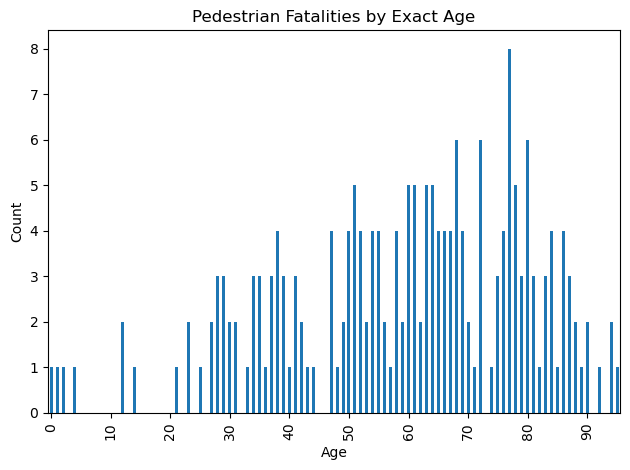

In [6]:
# visualize the count of each age
age_counts = df_ped['age'].value_counts().sort_index()

# If count is 0 for specific age, replace it with 0
full_ages = range(int(age_counts.index.min()), int(age_counts.index.max()) + 1)
age_counts = age_counts.reindex(full_ages, fill_value=0)


plt.figure()
age_counts.plot(kind='bar')
ages = age_counts.index.values
tick_positions = [i for i, a in enumerate(ages) if a % 10 == 0]   # Show only ticks at multiples of 10
tick_labels = [ages[i] for i in tick_positions]

plt.xticks(tick_positions, tick_labels)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Pedestrian Fatalities by Exact Age")
plt.tight_layout()
plt.savefig("../figures/Ped_age_count")
plt.show()

While exact ages are informative, grouped age categories are more interpretable for policy and public health analysis. We therefore bin ages into the following categories:
- 0–18 (children)
- 19–34 (young adults)
- 35–49 (midlife)
- 50–64 (pre-retirement)
- 65+ (older adults)


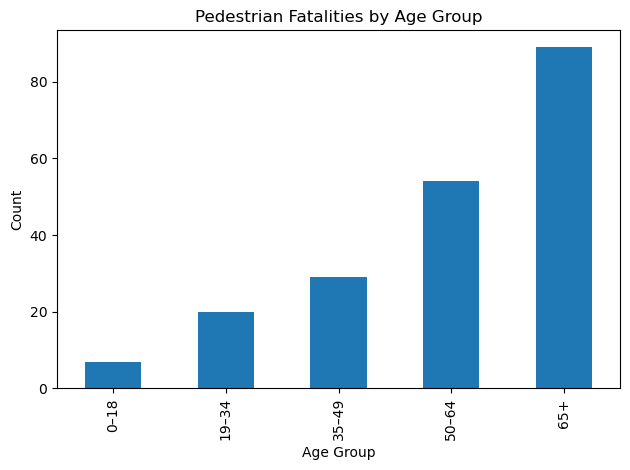

In [7]:
age_bins = [0, 19, 35, 50, 65, 120]
age_labels = ["0–18", "19–34", "35–49", "50–64", "65+"]

df_ped['age_group'] = pd.cut(
    df_ped['age'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

plt.figure()
df_ped['age_group'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Pedestrian Fatalities by Age Group")
plt.tight_layout()
plt.savefig("../figures/Ped_age_group")
plt.show()

The figure reveals a pattern consistent with previous results: Individuals aged 65 and above account for the largest share of deaths, followed by those aged 50–64. Children and young adults represent a relatively small fraction of fatalities.

## Gender

sex
Male      0.603015
Female    0.396985
Name: proportion, dtype: float64


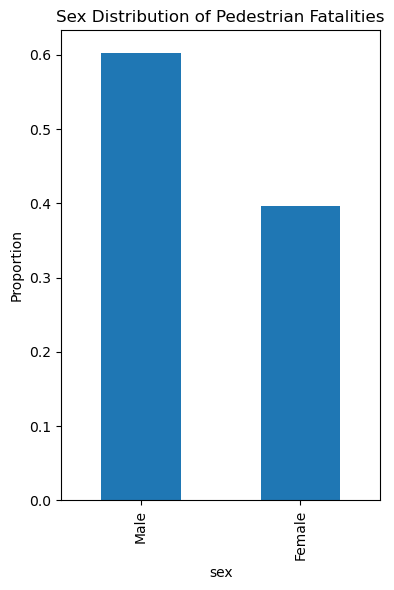

In [8]:
plt.figure(figsize=(4, 6))
print(df_ped['sex'].value_counts(normalize=True))
df_ped['sex'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel("Proportion")
plt.title("Sex Distribution of Pedestrian Fatalities")
plt.tight_layout()
plt.savefig("../figures/Ped_sex")
plt.show()

Pedestrian fatalities skew male, with males accounting for approximately 60% of deaths. However, the sex imbalance is less extreme than that in age. We may test whether such a skewness exist for male. Let $H_0: p= 0.5$ where $p$ denote the probability that a pedestrian fatality involves a male victim. A binomial test indicate that sex imbalance is significant.

In [9]:
import numpy as np
sex_mf = (
    df_ped["sex"]
    .astype(str)
    .str.strip()
    .str.title()
    .replace({"M": "Male", "F": "Female"})
)

n = len(sex_mf)
x_male = (sex_mf == "Male").sum()
p_hat = x_male / n if n > 0 else np.nan

print(f"Male/Female only: n={n}, male={x_male}, female={n-x_male}, p_hat={p_hat:.3f}")

# Exact binomial test: H0 p = 0.5 
from scipy.stats import binomtest
res = binomtest(x_male, n=n, p=0.5, alternative="two-sided")
print(f"Exact binomial test p-value (H0: p=0.5): {res.pvalue:.6g}")

# 95% CI for p (Clopper-Pearson exact)
ci = res.proportion_ci(confidence_level=0.95, method="exact")
print(f"95% CI for male proportion: [{ci.low:.3f}, {ci.high:.3f}]")

Male/Female only: n=199, male=120, female=79, p_hat=0.603
Exact binomial test p-value (H0: p=0.5): 0.00445503
95% CI for male proportion: [0.531, 0.672]


## Collision type
Finally, we examine the distribution of collision types involving pedestrians. The vast majority of pedestrian fatalities involve collisions with motor vehicles. Other collision types such as light rail vehicles, motorcycles, or buses, occur only rarely. This highlights motor vehicle traffic as the dominant source of pedestrian fatality risk.

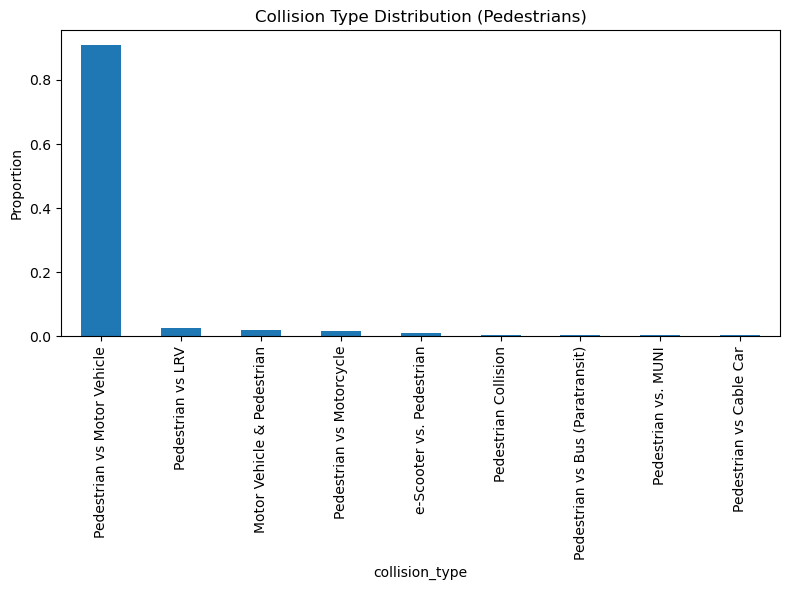

In [10]:
plt.figure(figsize=(8, 6))
df_ped['collision_type'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel("Proportion")
plt.title("Collision Type Distribution (Pedestrians)")
plt.tight_layout()
plt.savefig("../figures/Ped_collision_type")
plt.show()

# Temporal analysis

This section examines how pedestrian fatalities vary over time. Temporal analysis provides insight into both long-run trends and short-run daily patterns, which are critical for understanding pedestrian risk. We begin by analyzing pedestrian fatalities by calendar year. The time series exhibits noticeable variation across years. 

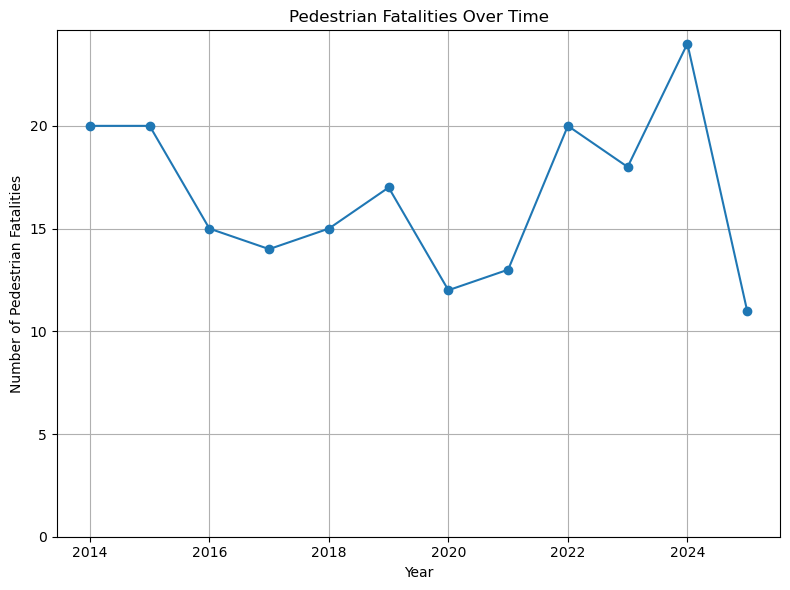

In [11]:
year_counts = df_ped["year"].value_counts().sort_index()

plt.figure(figsize=(8, 6))
year_counts.plot(kind="line", marker="o")
plt.xlabel("Year")
plt.ylabel("Number of Pedestrian Fatalities")
plt.title("Pedestrian Fatalities Over Time")
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/Ped_by_year")
plt.show()

To examine within-day temporal patterns, we use the dataset’s time_of_day variable, which include ranges
- Night (00–05)
- Morning (06–11)
- Afternoon (12–17)
- Evening (18–23)
The result shows that fewer fatalities occur during morning and afternoon periods.

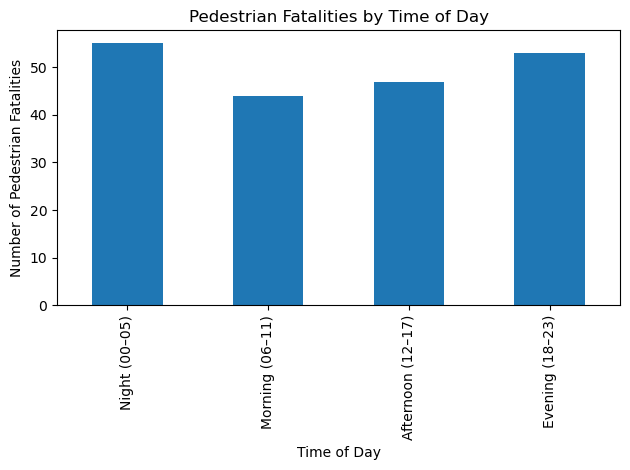

In [12]:
time_order = ["Night (00–05)", "Morning (06–11)", "Afternoon (12–17)", "Evening (18–23)"]
time_of_day_counts = (
    df_ped["time_of_day"]
    .value_counts()
    .reindex(time_order)
)


plt.figure()
time_of_day_counts.plot(kind="bar")
plt.xlabel("Time of Day")
plt.ylabel("Number of Pedestrian Fatalities")
plt.title("Pedestrian Fatalities by Time of Day")
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig("../figures/Ped_by_timeofday")
plt.show()

In [13]:
time_of_day_counts

time_of_day
Night (00–05)        55
Morning (06–11)      44
Afternoon (12–17)    47
Evening (18–23)      53
Name: count, dtype: int64

## Pedestrain-specific temporal pattern
To contextualize the pedestrian-specific temporal patterns, we compare them with analogous analyses conducted on the full dataset of fatal traffic crashes.

Overall traffic fatalities and pedestrian fatalities both show noticeable fluctuations across years, with increases and decreases occurring over relatively short time spans. Despite these similarities, peaks and troughs in pedestrian fatalities do not always coincide with those observed in total fatalities. In some years, pedestrian deaths rise even when total fatal crashes remain relatively stable, and vice versa. This divergence indicates that pedestrian fatalities are not merely a fixed proportion of overall traffic deaths. This suggests the influence of pedestrian-specific factors, such as changes in walking exposure, urban development, or pedestrian infrastructure, that may not affect other road users in the same way.

In the full dataset, fatal crashes are least frequent during morning hours, while night, afternoon, and evening periods all exhibit relatively high fatality counts. As for pedestrian fatalities, the distribution across morning, afternoon, evening, and night appears more balanced than in the full dataset and morning hours consistently represent a lower-risk period

# Spatial analysis
## Spatial heatmap
To examine geographic clustering of pedestrian fatalities, we construct a spatial density heatmap using the recorded latitude and longitude of each fatal pedestrian crash. 

The resulting heatmap shows that pedestrian fatalities are not uniformly distributed across space. Instead, they exhibit clear geographic clustering, with several localized areas displaying elevated concentrations of fatalities. These hotspots suggest persistent spatial patterns rather than isolated incidents.

It is important to note that the heatmap reflects raw fatality counts and does not account for pedestrian exposure or population density. As such, the visualization should be interpreted as indicating locations where fatalities occur repeatedly, rather than areas of elevated risk per pedestrian.

In [14]:
import folium
from folium.plugins import HeatMap

In [15]:
center = [df_ped['latitude'].mean(), df_ped['longitude'].mean()]
m = folium.Map(location=center, zoom_start=12, tiles="cartodbpositron")

def add_heat_layer(m, data, name, radius=15, blur=20):
    if len(data) == 0:
        return
    fg = folium.FeatureGroup(name=name, show=(name=="All Pedestrians"))
    HeatMap(
        data[['latitude', 'longitude']].values.tolist(),
        radius=radius,
        blur=blur,
        min_opacity=0.3
    ).add_to(fg)
    fg.add_to(m)

# All pedestrians
add_heat_layer(m, df_ped, "All Pedestrians")

# Per time_of_day layer
time_order = ["Night (00–05)", "Morning (06–11)", "Afternoon (12–17)", "Evening (18–23)"]
for t in time_order:
    sub = df_ped[df_ped["time_of_day"] == t]
    if len(sub) > 0:
        add_heat_layer(m, sub, t)

# Per year layer
years = sorted(df_ped["year"].dropna().unique())
for y in years:
    sub = df_ped[df_ped["year"] == y]
    add_heat_layer(m, sub, f"Year: {int(y)}")


# Age groups layer
age_bins = [0, 19, 35, 50, 65, 200]
age_labels = ["0–18", "19–34", "35–49", "50–64", "65+"]
df_ped["age_group"] = pd.cut(df_ped["age"], bins=age_bins, labels=age_labels, right=False)
for ag in age_labels:
    sub = df_ped[df_ped["age_group"] == ag]
    add_heat_layer(m, sub, f"Age: {ag}")

folium.LayerControl(collapsed=False).add_to(m)
m.save("../figures/Ped_heatmap.html")
m

## Neightborhood
To examine spatial concentration at a policy-relevant scale, we aggregate pedestrian fatalities by
`analysis_neighborhood` and examine the distribution of counts across neighborhoods.

Pedestrian fatalities are unevenly distributed across neighborhoods. A small number of neighborhoods
account for a disproportionately large share of pedestrian deaths. In particular, the top five
neighborhoods account for around 40% of all pedestrian fatalities, indicating strong
spatial concentration rather than uniform distribution across the city, which is consistent with the heatmap result.

In [16]:
# Count pedestrian fatalities by neighborhood
neigh_counts = (
    df_ped["analysis_neighborhood"]
    .value_counts()
    .rename("count")
)

# Top neighborhoods
top_neigh = neigh_counts.head(10)
top_neigh

analysis_neighborhood
Tenderloin                        21
South of Market                   17
Mission                           16
Bayview Hunters Point             15
Sunset/Parkside                   10
Marina                            10
West of Twin Peaks                10
Financial District/South Beach    10
Outer Richmond                     8
Excelsior                          7
Name: count, dtype: int64

In [17]:
total = neigh_counts.sum()

top5_share = neigh_counts.head(5).sum() / total
top10_share = neigh_counts.head(10).sum() / total

print(f"Top 5 neighborhoods account for {top5_share:.1%} of pedestrian fatalities")
print(f"Top 10 neighborhoods account for {top10_share:.1%} of pedestrian fatalities")

Top 5 neighborhoods account for 39.9% of pedestrian fatalities
Top 10 neighborhoods account for 62.6% of pedestrian fatalities


## Street
Since our sample size is small, exact fatality locations are rarely repeated. However, street names recur across multiple incidents. Therefore, we decided to extract street names from `location` and aggregate pedestrian fatalities by street.

This analysis shows that pedestrian fatalities are repeated along some major streets, even though exact addresses are unique. Note that a single fatality may occur at an intersection and contribute to multiple streets,
sum of street-level counts should be greater than the sample size.

In [18]:
import re

def extract_streets(loc):
    if pd.isna(loc):
        return []
    loc = loc.upper()
    # Remove boilerplate words
    loc = re.sub(r"INTERSECTION OF ", "", loc)
    loc = re.sub(r" BETWEEN .*", "", loc)
    # Split on common connectors
    streets = re.split(r" AND | AT | & |/", loc)
    return [s.strip() for s in streets if len(s.strip()) > 0]

# Apply
df_ped["streets"] = df_ped["location"].apply(extract_streets)

# Explode to one street per row
street_df = df_ped.explode("streets")

street_counts = street_df["streets"].value_counts()
street_counts.head(10)

streets
MISSION ST            8
GEARY BLVD            7
GEARY BOULEVARD       7
VAN NESS AVE          6
MISSION STREET        5
ULLOA ST              5
LENOX WAY             4
LOMBARD ST            4
16TH ST               4
GOLDEN GATE AVENUE    4
Name: count, dtype: int64

## Clustering
Previous results give us the intuition that some clustering patterns exist. To quantitatively assess global spatial clustering, we compute the Nearest Neighbor Index (NNI) based on the geographic coordinates of pedestrian fatalities. Recall that $$NNI=\frac{\text{Observed Mean Distance}}{\text{Expected Mean Distance}}$$
$NNI<1$ indicates a clustered pattern, $NNI=1$ suggests a random pattern and $NNI>1$ shows a dispersed pattern

Our test get $NNI=0.691$, providing evidence that pedestrian fatalities are spatially clustered rather than randomly distributed.

In [19]:
from scipy.spatial import KDTree

coords = df_ped[['latitude', 'longitude']].values

tree = KDTree(coords)
distances, _ = tree.query(coords, k=2)   # k=2 skips self-distance
nn_dist = distances[:, 1]

observed_mean = nn_dist.mean()

# expectation distance under complete spatial randomness
area = (
    (coords[:,0].max() - coords[:,0].min()) *
    (coords[:,1].max() - coords[:,1].min())
)
expected_mean = 0.5 / np.sqrt(len(coords) / area)

NNI = observed_mean / expected_mean

print(f"Observed mean NN distance: {observed_mean:.6f}")
print(f"Expected mean NN distance: {expected_mean:.6f}")
print(f"NNI: {NNI:.3f}")


Observed mean NN distance: 0.002920
Expected mean NN distance: 0.004224
NNI: 0.691


We then apply the DBSCAN clustering algorithm to the geographic coordinates. DBSCAN identifies seven spatial clusters, including one large cluster containing over sixty fatalities, as well as several smaller clusters. At the same time, roughly half of all fatalities are classified as noise. These results suggest that pedestrian fatalities are characterized by a combination of localized high-density areas and dispersed single events, consistent with previous results.

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(coords)

# DBSCAN parameters (tunable)
db = DBSCAN(eps=0.15, min_samples=4).fit(X)
df_ped["cluster"] = db.labels_

n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = (db.labels_ == -1).sum()

print(f"Number of clusters detected: {n_clusters}")
print(f"Number of noise points: {n_noise}")

# Show cluster sizes
cluster_sizes = (
    df_ped[df_ped["cluster"] != -1]
    .groupby("cluster")
    .size()
    .sort_values(ascending=False)
)

cluster_sizes

Number of clusters detected: 7
Number of noise points: 101


cluster
0    62
2    11
3     9
1     4
4     4
5     4
6     4
dtype: int64

Finally, we visualize the DBSCAN clusters.

In [21]:
from folium.plugins import MarkerCluster
m = folium.Map(location=center, zoom_start=12, tiles="cartodbpositron")
palette = [
    "red", "blue", "green", "purple", "orange", "darkred", "cadetblue",
    "darkblue", "darkgreen", "pink", "gray", "black"
]

clusters = sorted([c for c in df_ped["cluster"].unique() if c != -1])
cluster_sizes = df_ped[df_ped["cluster"] != -1].groupby("cluster").size().to_dict()

# Add cluster layers
for i, c in enumerate(clusters):
    color = palette[i % len(palette)]
    fg = folium.FeatureGroup(name=f"Cluster {c} (n={cluster_sizes.get(c, 0)})", show=(c == clusters[0]))
    mc = MarkerCluster().add_to(fg)
    sub = df_ped[df_ped["cluster"] == c]
    for _, r in sub.iterrows():
        folium.CircleMarker(
            location=[r['latitude'], r['longitude']],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.8,
            weight=1,
            tooltip=f"Cluster {c}"
        ).add_to(mc)
    fg.add_to(m)

# Add noise points as separate layer
noise = df_ped[df_ped["cluster"] == -1]
fg_noise = folium.FeatureGroup(name=f"Noise (n={len(noise)})", show=False)
mc_noise = MarkerCluster().add_to(fg_noise)
for _, r in noise.iterrows():
    folium.CircleMarker(
        location=[r['latitude'], r['longitude']],
        radius=3,
        color="lightgray",
        fill=True,
        fill_opacity=0.6,
        weight=1,
        tooltip="Noise"
    ).add_to(mc_noise)
fg_noise.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("../figures/DBSCAN_cluster")
m